In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
import numpy as np
import dataset_utils
import importlib
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
from sklearn.preprocessing import StandardScaler

importlib.reload(dataset_utils)

<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

# Read dataset

In [2]:
species2genus = torch.load('tensor_dataset/species2genus.pt')
described_species_train = torch.load('tensor_dataset/described_species_labels_train.pt')
described_species_trainval = torch.load('tensor_dataset/described_species_labels_trainval.pt')
described_species_labels = described_species_train

In [3]:
expanded_train_dna_features = torch.load('dna_train_features.pt')
expanded_train_dna_labels = torch.load('dna_train_labels.pt')
image_train_features = torch.load('img_train_features.pt')
image_train_labels= torch.load('img_train_labels.pt')
assert((image_train_labels == expanded_train_dna_labels).all())

In [4]:
expanded_val_dna_features = torch.load('dna_val_features.pt')
expanded_val_dna_labels = torch.load('dna_val_labels.pt')
image_val_features = torch.load('img_val_features.pt')
image_val_labels = torch.load('img_val_labels.pt')
assert((image_val_labels == expanded_val_dna_labels).all())

In [5]:
expanded_test_dna_features = torch.load('dna_test_features.pt')
expanded_test_dna_labels = torch.load('dna_test_labels.pt')
image_test_features = torch.load('img_test_features.pt')
image_test_labels = torch.load('img_test_labels.pt')
assert((image_test_labels == expanded_test_dna_labels).all())
n_classes = 1050

In [6]:
torch.load('tensor_dataset/all_dnas.pt').mean()

tensor(0.1997, dtype=torch.float64)

In [7]:
expanded_train_dna_features.mean()

tensor(0.3692)

In [8]:
import scipy.io as io
using_matlab_dataset  = False
if using_matlab_dataset:
    dset = io.loadmat('matlab_dataset/insect_dataset.mat') 
    all_dna_features_cnn_original = dset['all_dna_features_cnn_original']
    all_image_features_resnet = dset['all_image_features_resnet']
    train_loc = np.squeeze(dset['train_loc']-1)
    val_seen_loc = np.squeeze(dset['val_seen_loc']-1)
    val_unseen_loc = np.squeeze(dset['val_unseen_loc']-1)
    test_seen_loc = np.squeeze(dset['test_seen_loc']-1)
    test_unseen_loc = np.squeeze(dset['test_unseen_loc']-1)
    expanded_train_dna_features = torch.tensor(all_dna_features_cnn_original[train_loc])
    expanded_val_dna_features = torch.tensor(all_dna_features_cnn_original[np.concatenate((val_seen_loc,val_unseen_loc))])
    expanded_test_dna_features = torch.tensor(all_dna_features_cnn_original[np.concatenate((test_seen_loc,test_unseen_loc))])
    
    image_train_features = torch.tensor(all_image_features_resnet[train_loc])
    image_val_features = torch.tensor(all_image_features_resnet[np.concatenate((val_seen_loc,val_unseen_loc))])
    image_test_features = torch.tensor(all_image_features_resnet[np.concatenate((test_seen_loc,test_unseen_loc))])
first_layer_size = image_train_features.shape[1] + expanded_train_dna_features.shape[1]


In [9]:
class InsectNet(torch.nn.Module):
    def __init__(self):
        super(InsectNet, self).__init__()
        self.dout = nn.Dropout(p=0.8)
        self.linear1 = nn.Linear(first_layer_size,372)
        self.act1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(372,n_classes)
        self.act2 = nn.LogSoftmax()
    def forward(self, x, temperature = 1):
        x = self.dout(x)
        x = self.linear1(x)
        x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x/temperature)#species log probabilities
        return x,x_genus

In [10]:
image_train_features.shape

torch.Size([13039, 2048])

In [11]:
image_train_labels.shape

torch.Size([13039])

In [12]:
expanded_train_dna_features.shape

torch.Size([13039, 3250])

In [13]:
expanded_train_dna_labels.shape


torch.Size([13039])

In [14]:
expanded_train_dna_features.mean()

tensor(0.3692)

# Choose if training on train or train+val and feature normalization

In [15]:
is_train_val = True# USE TRUE HERE IF ITS THE FINAL EVALUATION AND YOU WANT TO TRAIN ON TRAIN+VAL AND EVALUATE ON TEST
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)
complete_test_features = torch.cat((expanded_test_dna_features,image_test_features),dim=1)
if is_train_val:
    complete_train_features = torch.cat((complete_train_features,complete_val_features),dim=0)
    complete_val_features = complete_test_features
    image_train_labels = torch.cat((image_train_labels,image_val_labels),dim=0)
    image_val_labels = image_test_labels
    described_species_labels = described_species_trainval

scaler = StandardScaler()
complete_train_features_scaled = scaler.fit_transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

In [52]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features_scaled, image_train_labels)
train_predicted_labels = clf.predict(complete_train_features_scaled)
print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==image_train_labels.numpy())/len(image_train_labels)}")
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==image_val_labels.numpy())/len(image_val_labels)}")
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation genus accuracy:{np.count_nonzero(species2genus[val_predicted_labels.astype(int)]==species2genus[(image_val_labels.long().numpy())])/len(image_val_labels)}")




Training species accuracy:1.0
Validation species accuracy:0.39718423169750605
Validation genus accuracy:0.8339501206757844


In [17]:
from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)

In [18]:
species2genus.min()
#species2genus.max()

tensor(0)

In [19]:
species2genus.shape

torch.Size([1050, 1])

In [20]:
complete_train_features_scaled.shape

torch.Size([19994, 5298])

# Fitting model

In [21]:
from torch.utils.data import DataLoader
batch_size = 1000
train_loader = DataLoader(d_train,shuffle=True,batch_size = batch_size)
val_loader = DataLoader(d_val,shuffle=True,batch_size = batch_size)
dataloaders = {'train':train_loader,'val':val_loader}
dataset_sizes = {'train':len(d_train.targets),'val':len(d_val.targets)}

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = InsectNet().to(device)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=5)

In [23]:
from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.NLLLoss()
    if device == 'cuda:0':
        torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        running_train_corrects_genus = 0
        for features,labels in tqdm(dataloaders['train']):
            model.train()
            genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
            features = features.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()
            predicted_labels,predicted_genus_labels = model(features)
            
            train_loss = criterion(predicted_labels,labels)
            train_genus_loss = criterion(predicted_genus_labels,genus_labels)
            train_loss+=train_genus_loss
            train_loss.backward()
            optimizer.step()
            scheduler.step()
            
            _, preds = torch.max(predicted_labels, 1)
            _, genus_preds = torch.max(predicted_genus_labels, 1)
            running_train_corrects += torch.sum(preds == labels.data)
            running_train_corrects_genus += torch.sum(genus_preds == genus_labels)
        train_losses.append(train_loss)
        running_val_corrects = 0
        running_val_corrects_genus = 0
        for features,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
                features = features.to(device)
                labels = labels.type(torch.LongTensor).to(device)
                optimizer.zero_grad()
                
                predicted_labels,predicted_genus_labels = model(features)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                _, genus_preds = torch.max(predicted_genus_labels, 1)
                running_val_corrects += torch.sum(preds == labels.data)
                running_val_corrects_genus += torch.sum(genus_preds == genus_labels)
        val_losses.append(val_loss)
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_train_acc_genus = running_train_corrects_genus.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        epoch_val_acc_genus = running_val_corrects_genus.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}, genus train_score{:.4f}, genus val_score{:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc,epoch_train_acc_genus,epoch_val_acc_genus))
    return train_losses

In [23]:

_ = fit(100,dataloaders,optimizer,model)

  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipykernel_36750/2367995586.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)
/tmp/ipykernel_36750/1170044867.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [1/100], train_loss: 6.2416,  train_score: 0.1863,val_loss: 7.3759,  val_score: 0.1355, genus train_score0.4087, genus val_score0.7383


/tmp/ipykernel_36750/2367995586.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  genus_labels = torch.tensor(species2genus[labels.int()]).squeeze().to(device)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [2/100], train_loss: 3.6107,  train_score: 0.4268,val_loss: 8.5245,  val_score: 0.2382, genus train_score0.8540, genus val_score0.8737


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [3/100], train_loss: 2.2639,  train_score: 0.6491,val_loss: 8.5210,  val_score: 0.3005, genus train_score0.9522, genus val_score0.9044


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [4/100], train_loss: 1.3718,  train_score: 0.7916,val_loss: 9.0032,  val_score: 0.3447, genus train_score0.9726, genus val_score0.9119


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [5/100], train_loss: 0.7296,  train_score: 0.9038,val_loss: 8.5039,  val_score: 0.3759, genus train_score0.9798, genus val_score0.9163


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [6/100], train_loss: 0.4413,  train_score: 0.9539,val_loss: 9.2816,  val_score: 0.3870, genus train_score0.9861, genus val_score0.9204


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [7/100], train_loss: 0.3055,  train_score: 0.9690,val_loss: 8.9437,  val_score: 0.3907, genus train_score0.9882, genus val_score0.9237


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [8/100], train_loss: 0.2230,  train_score: 0.9774,val_loss: 9.3401,  val_score: 0.3929, genus train_score0.9897, genus val_score0.9258


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [9/100], train_loss: 0.1697,  train_score: 0.9820,val_loss: 9.2519,  val_score: 0.3940, genus train_score0.9924, genus val_score0.9270


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [10/100], train_loss: 0.1349,  train_score: 0.9837,val_loss: 8.5455,  val_score: 0.3943, genus train_score0.9931, genus val_score0.9273


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [11/100], train_loss: 0.1246,  train_score: 0.9891,val_loss: 8.8068,  val_score: 0.3950, genus train_score0.9938, genus val_score0.9269


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [12/100], train_loss: 0.1037,  train_score: 0.9890,val_loss: 9.4585,  val_score: 0.3950, genus train_score0.9949, genus val_score0.9283


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [13/100], train_loss: 0.1080,  train_score: 0.9895,val_loss: 9.8283,  val_score: 0.3951, genus train_score0.9956, genus val_score0.9275


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [14/100], train_loss: 0.0745,  train_score: 0.9903,val_loss: 9.1157,  val_score: 0.3961, genus train_score0.9968, genus val_score0.9281


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [15/100], train_loss: 0.0598,  train_score: 0.9921,val_loss: 9.2292,  val_score: 0.3959, genus train_score0.9968, genus val_score0.9285


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [16/100], train_loss: 0.0676,  train_score: 0.9947,val_loss: 9.6069,  val_score: 0.3963, genus train_score0.9973, genus val_score0.9291


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [17/100], train_loss: 0.0585,  train_score: 0.9938,val_loss: 9.2442,  val_score: 0.3968, genus train_score0.9978, genus val_score0.9292


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [18/100], train_loss: 0.0472,  train_score: 0.9939,val_loss: 9.1455,  val_score: 0.3966, genus train_score0.9979, genus val_score0.9293


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [19/100], train_loss: 0.0456,  train_score: 0.9950,val_loss: 9.0845,  val_score: 0.3970, genus train_score0.9983, genus val_score0.9291


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [20/100], train_loss: 0.0418,  train_score: 0.9951,val_loss: 9.6579,  val_score: 0.3968, genus train_score0.9980, genus val_score0.9295


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [21/100], train_loss: 0.0464,  train_score: 0.9952,val_loss: 10.1418,  val_score: 0.3969, genus train_score0.9990, genus val_score0.9305


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [22/100], train_loss: 0.0353,  train_score: 0.9954,val_loss: 9.3362,  val_score: 0.3969, genus train_score0.9984, genus val_score0.9303


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [23/100], train_loss: 0.0600,  train_score: 0.9955,val_loss: 9.6234,  val_score: 0.3973, genus train_score0.9984, genus val_score0.9298


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [24/100], train_loss: 0.0380,  train_score: 0.9948,val_loss: 9.9831,  val_score: 0.3970, genus train_score0.9986, genus val_score0.9296


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [25/100], train_loss: 0.0309,  train_score: 0.9968,val_loss: 8.9049,  val_score: 0.3972, genus train_score0.9986, genus val_score0.9291


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [26/100], train_loss: 0.0271,  train_score: 0.9953,val_loss: 9.8816,  val_score: 0.3965, genus train_score0.9991, genus val_score0.9292


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [27/100], train_loss: 0.0303,  train_score: 0.9942,val_loss: 9.3001,  val_score: 0.3969, genus train_score0.9991, genus val_score0.9290


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [28/100], train_loss: 0.0178,  train_score: 0.9965,val_loss: 9.4035,  val_score: 0.3976, genus train_score0.9992, genus val_score0.9296


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [29/100], train_loss: 0.0287,  train_score: 0.9969,val_loss: 9.3213,  val_score: 0.3973, genus train_score0.9992, genus val_score0.9294


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [30/100], train_loss: 0.0333,  train_score: 0.9974,val_loss: 10.6040,  val_score: 0.3975, genus train_score0.9987, genus val_score0.9302


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [31/100], train_loss: 0.0248,  train_score: 0.9967,val_loss: 9.1965,  val_score: 0.3974, genus train_score0.9992, genus val_score0.9310


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [32/100], train_loss: 0.0244,  train_score: 0.9974,val_loss: 9.7101,  val_score: 0.3975, genus train_score0.9991, genus val_score0.9312


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [33/100], train_loss: 0.0244,  train_score: 0.9970,val_loss: 9.5544,  val_score: 0.3976, genus train_score0.9992, genus val_score0.9320


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [34/100], train_loss: 0.0173,  train_score: 0.9976,val_loss: 9.4912,  val_score: 0.3975, genus train_score0.9993, genus val_score0.9329


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [35/100], train_loss: 0.0213,  train_score: 0.9979,val_loss: 9.5235,  val_score: 0.3973, genus train_score0.9993, genus val_score0.9328


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [36/100], train_loss: 0.0202,  train_score: 0.9975,val_loss: 10.2977,  val_score: 0.3977, genus train_score0.9992, genus val_score0.9317


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [37/100], train_loss: 0.0183,  train_score: 0.9974,val_loss: 10.1761,  val_score: 0.3977, genus train_score0.9995, genus val_score0.9307


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [38/100], train_loss: 0.0139,  train_score: 0.9966,val_loss: 9.2558,  val_score: 0.3975, genus train_score0.9994, genus val_score0.9311


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [39/100], train_loss: 0.0190,  train_score: 0.9973,val_loss: 9.9113,  val_score: 0.3974, genus train_score0.9995, genus val_score0.9313


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [40/100], train_loss: 0.0282,  train_score: 0.9978,val_loss: 9.2043,  val_score: 0.3977, genus train_score0.9995, genus val_score0.9319


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [41/100], train_loss: 0.0142,  train_score: 0.9985,val_loss: 9.5285,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9323


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [42/100], train_loss: 0.0147,  train_score: 0.9983,val_loss: 9.4431,  val_score: 0.3976, genus train_score0.9995, genus val_score0.9323


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [43/100], train_loss: 0.0119,  train_score: 0.9981,val_loss: 9.0890,  val_score: 0.3977, genus train_score0.9993, genus val_score0.9322


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [44/100], train_loss: 0.0207,  train_score: 0.9978,val_loss: 9.2230,  val_score: 0.3975, genus train_score0.9994, genus val_score0.9315


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [45/100], train_loss: 0.0094,  train_score: 0.9984,val_loss: 9.8432,  val_score: 0.3977, genus train_score0.9994, genus val_score0.9317


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [46/100], train_loss: 0.0101,  train_score: 0.9976,val_loss: 9.5219,  val_score: 0.3977, genus train_score0.9995, genus val_score0.9313


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [47/100], train_loss: 0.0104,  train_score: 0.9988,val_loss: 9.6757,  val_score: 0.3977, genus train_score0.9994, genus val_score0.9312


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [48/100], train_loss: 0.0085,  train_score: 0.9981,val_loss: 10.3194,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9312


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [49/100], train_loss: 0.0157,  train_score: 0.9972,val_loss: 9.9731,  val_score: 0.3977, genus train_score0.9995, genus val_score0.9316


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [50/100], train_loss: 0.0123,  train_score: 0.9973,val_loss: 9.3967,  val_score: 0.3976, genus train_score0.9995, genus val_score0.9320


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [51/100], train_loss: 0.0089,  train_score: 0.9982,val_loss: 9.5698,  val_score: 0.3977, genus train_score0.9993, genus val_score0.9323


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [52/100], train_loss: 0.0083,  train_score: 0.9982,val_loss: 10.2429,  val_score: 0.3978, genus train_score0.9996, genus val_score0.9327


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [53/100], train_loss: 0.0087,  train_score: 0.9986,val_loss: 9.2275,  val_score: 0.3977, genus train_score0.9995, genus val_score0.9327


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [54/100], train_loss: 0.0088,  train_score: 0.9982,val_loss: 9.5133,  val_score: 0.3975, genus train_score0.9996, genus val_score0.9329


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [55/100], train_loss: 0.0112,  train_score: 0.9986,val_loss: 9.0906,  val_score: 0.3977, genus train_score0.9999, genus val_score0.9331


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [56/100], train_loss: 0.0107,  train_score: 0.9986,val_loss: 9.1295,  val_score: 0.3975, genus train_score0.9998, genus val_score0.9337


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [57/100], train_loss: 0.0088,  train_score: 0.9983,val_loss: 9.9236,  val_score: 0.3976, genus train_score0.9996, genus val_score0.9339


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [58/100], train_loss: 0.0152,  train_score: 0.9980,val_loss: 9.9194,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9347


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [59/100], train_loss: 0.0117,  train_score: 0.9978,val_loss: 9.9278,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9342


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [60/100], train_loss: 0.0056,  train_score: 0.9980,val_loss: 9.7913,  val_score: 0.3973, genus train_score0.9999, genus val_score0.9337


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [61/100], train_loss: 0.0088,  train_score: 0.9984,val_loss: 9.9431,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9331


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [62/100], train_loss: 0.0079,  train_score: 0.9981,val_loss: 9.6257,  val_score: 0.3975, genus train_score0.9997, genus val_score0.9338


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [63/100], train_loss: 0.0110,  train_score: 0.9980,val_loss: 9.9497,  val_score: 0.3973, genus train_score0.9997, genus val_score0.9339


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [64/100], train_loss: 0.0071,  train_score: 0.9982,val_loss: 9.5979,  val_score: 0.3978, genus train_score0.9998, genus val_score0.9336


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [65/100], train_loss: 0.0152,  train_score: 0.9983,val_loss: 9.1639,  val_score: 0.3976, genus train_score0.9998, genus val_score0.9338


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [66/100], train_loss: 0.0091,  train_score: 0.9989,val_loss: 9.1609,  val_score: 0.3973, genus train_score0.9997, genus val_score0.9341


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [67/100], train_loss: 0.0066,  train_score: 0.9986,val_loss: 9.4185,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9339


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [68/100], train_loss: 0.0058,  train_score: 0.9981,val_loss: 9.2370,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9344


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [69/100], train_loss: 0.0053,  train_score: 0.9982,val_loss: 9.6055,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9340


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [70/100], train_loss: 0.0058,  train_score: 0.9985,val_loss: 9.4206,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9340


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [71/100], train_loss: 0.0086,  train_score: 0.9987,val_loss: 9.2946,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9344


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [72/100], train_loss: 0.0089,  train_score: 0.9982,val_loss: 9.3350,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9343


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [73/100], train_loss: 0.0061,  train_score: 0.9980,val_loss: 8.5957,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9337


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [74/100], train_loss: 0.0184,  train_score: 0.9969,val_loss: 8.8911,  val_score: 0.3971, genus train_score0.9995, genus val_score0.9342


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [75/100], train_loss: 0.0106,  train_score: 0.9980,val_loss: 8.7608,  val_score: 0.3978, genus train_score0.9995, genus val_score0.9331


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [76/100], train_loss: 0.0095,  train_score: 0.9978,val_loss: 8.8253,  val_score: 0.3980, genus train_score0.9997, genus val_score0.9316


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [77/100], train_loss: 0.0057,  train_score: 0.9989,val_loss: 8.3397,  val_score: 0.3976, genus train_score0.9999, genus val_score0.9323


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [78/100], train_loss: 0.0053,  train_score: 0.9985,val_loss: 8.9334,  val_score: 0.3976, genus train_score0.9998, genus val_score0.9328


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [79/100], train_loss: 0.0169,  train_score: 0.9978,val_loss: 8.9101,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9327


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [80/100], train_loss: 0.0055,  train_score: 0.9980,val_loss: 8.9699,  val_score: 0.3975, genus train_score0.9997, genus val_score0.9330


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [81/100], train_loss: 0.0037,  train_score: 0.9989,val_loss: 8.5236,  val_score: 0.3978, genus train_score0.9998, genus val_score0.9340


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [82/100], train_loss: 0.0063,  train_score: 0.9986,val_loss: 9.5965,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9341


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [83/100], train_loss: 0.0120,  train_score: 0.9985,val_loss: 9.2256,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9345


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [84/100], train_loss: 0.0052,  train_score: 0.9987,val_loss: 8.4776,  val_score: 0.3976, genus train_score0.9996, genus val_score0.9338


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [85/100], train_loss: 0.0060,  train_score: 0.9985,val_loss: 8.3473,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9335


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [86/100], train_loss: 0.0057,  train_score: 0.9988,val_loss: 9.0591,  val_score: 0.3975, genus train_score0.9998, genus val_score0.9344


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [87/100], train_loss: 0.0040,  train_score: 0.9989,val_loss: 8.6702,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9344


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [88/100], train_loss: 0.0065,  train_score: 0.9985,val_loss: 9.3103,  val_score: 0.3975, genus train_score0.9997, genus val_score0.9337


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [89/100], train_loss: 0.0047,  train_score: 0.9992,val_loss: 8.7642,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9337


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [90/100], train_loss: 0.0067,  train_score: 0.9985,val_loss: 8.6548,  val_score: 0.3977, genus train_score0.9998, genus val_score0.9332


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [91/100], train_loss: 0.0034,  train_score: 0.9986,val_loss: 8.9442,  val_score: 0.3975, genus train_score0.9997, genus val_score0.9329


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [92/100], train_loss: 0.0039,  train_score: 0.9985,val_loss: 9.0741,  val_score: 0.3977, genus train_score0.9999, genus val_score0.9329


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [93/100], train_loss: 0.0072,  train_score: 0.9984,val_loss: 8.2387,  val_score: 0.3976, genus train_score0.9999, genus val_score0.9332


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [94/100], train_loss: 0.0095,  train_score: 0.9986,val_loss: 8.9712,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9331


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [95/100], train_loss: 0.0163,  train_score: 0.9983,val_loss: 8.8913,  val_score: 0.3977, genus train_score0.9996, genus val_score0.9330


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [96/100], train_loss: 0.0027,  train_score: 0.9991,val_loss: 8.7226,  val_score: 0.3977, genus train_score0.9999, genus val_score0.9333


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [97/100], train_loss: 0.0052,  train_score: 0.9989,val_loss: 8.2618,  val_score: 0.3977, genus train_score0.9997, genus val_score0.9330


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [98/100], train_loss: 0.0094,  train_score: 0.9986,val_loss: 8.7735,  val_score: 0.3978, genus train_score0.9998, genus val_score0.9329


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [99/100], train_loss: 0.0029,  train_score: 0.9986,val_loss: 8.2154,  val_score: 0.3976, genus train_score0.9997, genus val_score0.9333


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Epoch [100/100], train_loss: 0.0042,  train_score: 0.9988,val_loss: 8.4921,  val_score: 0.3976, genus train_score0.9998, genus val_score0.9331


# Estrazione features unseen dataset .mat

In [39]:
import scipy.io as io
from sklearn.model_selection import train_test_split
data = io.loadmat('get_unseen_fresh_samples/unseen_insect_dataset.mat')
all_image_features = data['all_image_features_gan']
all_dna_features = data['all_dna_features_cnn_new']
all_genus_labels = np.squeeze(data['all_genus_labels'])-1
X = np.concatenate((all_image_features,all_dna_features),axis=1)
#X=scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, all_genus_labels, test_size=0.50, random_state=42)



In [50]:
xxxxx =clf.predict(X)

In [51]:
xxxxx

array([54, 54, 54, ..., 54, 54, 54])

In [46]:
np.count_nonzero(xxxxx!=976)

3691

In [47]:
3691/40000

0.092275

In [32]:
X.mean()

0.22461118

In [37]:
complete_train_features_scaled[0].mean()

tensor(0.0402)

In [35]:
complete_train_features.mean()

tensor(0.2315)

In [36]:
X_scaled[0].mean()

39.554504

In [29]:
complete_train_features_scaled.shape

torch.Size([19994, 5298])

(40050, 5298)

In [25]:
X.mean()

0.22461118

In [26]:
all_genus_labels.min()

0

In [27]:
print(data['all_dna_features_cnn_new'].mean())
print(expanded_train_dna_features.mean())
print(expanded_val_dna_features.mean())
print(expanded_test_dna_features.mean())

0.3596095
tensor(0.3692)
tensor(0.3713)
tensor(0.3715)


In [28]:
print(data['all_dna_features_cnn_new'].std())
print(expanded_train_dna_features.std())
print(expanded_val_dna_features.std())
print(expanded_test_dna_features.std())

1.1701347
tensor(1.1705)
tensor(1.1715)
tensor(1.1716)


In [29]:
y_test

array([ 30,  95, 199, ...,  25, 288, 285])

In [30]:
all_image_features.mean()

0.01038311

In [31]:
complete_train_features_scaled.mean()

tensor(7.3753e-11)

In [32]:
complete_train_features = X_train
complete_val_features = X_test
image_train_labels = y_train
image_val_labels = y_test
#described_species_labels = described_species_trainval

#scaler = StandardScaler()
complete_train_features_scaled = scaler.transform(complete_train_features)
complete_val_features_scaled = scaler.transform(complete_val_features)

from torch.utils.data import Dataset
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index].type(torch.LongTensor)
        
        #if self.transform:
        #    x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
        #    x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)
complete_train_features_scaled = torch.tensor(complete_train_features_scaled,dtype=torch.float)
complete_val_features_scaled = torch.tensor(complete_val_features_scaled,dtype=torch.float)

d_train = FeatureDataset(complete_train_features_scaled,image_train_labels)
d_val = FeatureDataset(complete_val_features_scaled,image_val_labels)


In [113]:
d_train.data.shape[0]+d_val.data.shape[0]

40050

In [34]:
complete_val_features_scaled.mean()

tensor(41.0501)

In [35]:
image_val_labels

array([ 30,  95, 199, ...,  25, 288, 285])

In [36]:
image_train_labels

array([ 95, 269,  95, ...,  68, 158, 254])

In [37]:
train_predicted_labels

NameError: name 'train_predicted_labels' is not defined

In [38]:
# try dataset with forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features_scaled, image_train_labels)
train_predicted_labels = clf.predict(complete_train_features_scaled)
print(f"Training genus accuracy:{np.count_nonzero(train_predicted_labels==image_train_labels)/len(image_train_labels)}")
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==image_val_labels)/len(image_val_labels)}")

Training genus accuracy:0.9998002496878902
Validation genus accuracy:0.9144569288389514


In [39]:
val_predicted_labels= clf.predict(complete_val_features_scaled)
print(f"Validation genus accuracy:{np.count_nonzero(species2genus[val_predicted_labels.astype(int)].numpy().squeeze()==image_val_labels)/len(image_val_labels)}")


Validation genus accuracy:0.0004993757802746567


In [40]:
(species2genus[val_predicted_labels.astype(int)].numpy().squeeze()==image_val_labels)

array([False, False, False, ..., False, False, False])

In [41]:
image_val_labels

array([ 30,  95, 199, ...,  25, 288, 285])

In [42]:
torch.cuda.empty_cache()
with torch.no_grad():
    model.eval()
    val_predicted_probs,val_predicted_probs_genus = (model(d_val.data.cuda(),temperature=1))
    val_predicted_probs = torch.exp(val_predicted_probs)
    val_predicted_probs_genus = torch.exp(val_predicted_probs_genus)
val_predicted_probs = val_predicted_probs.cpu()
val_predicted_probs_genus = val_predicted_probs_genus.cpu()

/tmp/ipykernel_36750/1170044867.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x_genus = torch.nn.functional.log_softmax(x/temperature)#genus log probabilities
/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [43]:
val_predicted_labels = val_predicted_probs.argmax(axis=1)
val_predicted_labels_genus = val_predicted_probs_genus.argmax(axis=1)
image_val_labels = torch.tensor(image_val_labels).type(torch.LongTensor)

In [44]:
val_predicted_probs_genus[0].argmax()

tensor(114)

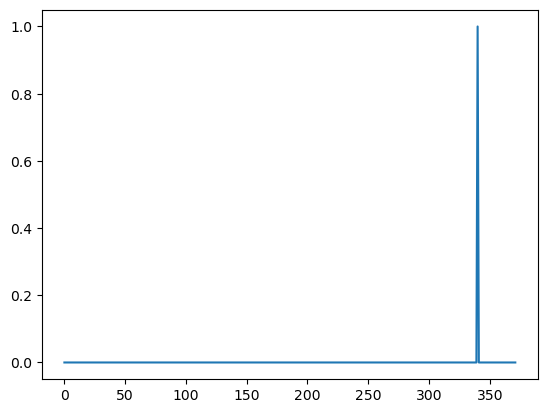

In [45]:
#example of output probabilities for undescribed insect
plt.plot(val_predicted_probs_genus[-1].cpu())
#plt.savefig("peaks10.png")

In [46]:
image_val_labels

tensor([ 30,  95, 199,  ...,  25, 288, 285])

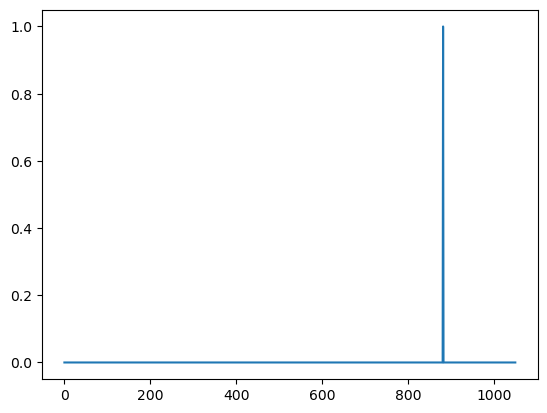

In [47]:
plt.plot(val_predicted_probs[1].cpu())


In [48]:
val_predicted_probs[1].topk(2)

torch.return_types.topk(
values=tensor([1.0000e+00, 1.5723e-21]),
indices=tensor([881, 377]))

In [49]:
val_predicted_probs_genus[1].topk(2)

torch.return_types.topk(
values=tensor([1., 0.]),
indices=tensor([165,   0]))

In [50]:
species2genus[699]

tensor([287])

In [51]:
[x for x in range(len(species2genus)) if species2genus[x]==287]

[699]

In [52]:
max(image_val_labels)

tensor(371)

In [53]:
species2genus

tensor([[234],
        [234],
        [235],
        ...,
        [ 44],
        [ 44],
        [311]])

In [54]:
val_predicted_labels

tensor([298, 881, 852,  ..., 881, 298, 819])

In [55]:
for x in val_predicted_labels_genus:
    print(x)

tensor(114)
tensor(165)
tensor(165)
tensor(145)
tensor(165)
tensor(40)
tensor(165)
tensor(165)
tensor(336)
tensor(145)
tensor(145)
tensor(114)
tensor(340)
tensor(340)
tensor(165)
tensor(145)
tensor(145)
tensor(340)
tensor(228)
tensor(165)
tensor(145)
tensor(145)
tensor(340)
tensor(165)
tensor(145)
tensor(336)
tensor(340)
tensor(134)
tensor(145)
tensor(145)
tensor(340)
tensor(340)
tensor(145)
tensor(165)
tensor(145)
tensor(165)
tensor(108)
tensor(145)
tensor(340)
tensor(336)
tensor(145)
tensor(165)
tensor(165)
tensor(145)
tensor(353)
tensor(87)
tensor(137)
tensor(336)
tensor(85)
tensor(340)
tensor(340)
tensor(145)
tensor(319)
tensor(85)
tensor(114)
tensor(145)
tensor(145)
tensor(336)
tensor(340)
tensor(48)
tensor(340)
tensor(40)
tensor(165)
tensor(165)
tensor(13)
tensor(145)
tensor(145)
tensor(131)
tensor(340)
tensor(165)
tensor(36)
tensor(165)
tensor(145)
tensor(145)
tensor(340)
tensor(340)
tensor(145)
tensor(165)
tensor(165)
tensor(145)
tensor(114)
tensor(145)
tensor(134)
tensor(145)


In [56]:
y_test

array([ 30,  95, 199, ...,  25, 288, 285])

# top2 method to choose either genus or species as output

In [57]:
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
thresholds = []
possible_thresholds = [x / 10000 for x in range(0, 10000, 1000)]
for t in possible_thresholds:
    thresholds.append(t)
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        label_best_specie = val_predicted_labels[i]
       
        #assert val_predicted_labels[i]==val_predicted_probs[i].argmax(), f"{val_predicted_labels[i]}=={val_predicted_probs[i].argmax()}"
        genus_of_best_species = species2genus[label_best_specie.item()]

        top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO
        #print(top2)
        if  False and (top2.values[0]-top2.values[1]) >t*top2.values[0]:#species 
            print(f"threshold:{t}")
            n_undescribed_samples+=1
        else:#genus
            #print(f"genus:{t}")

            n_undescribed_samples+=1
            #if genus_of_best_species == species2genus[image_val_labels[i]]:#guessed genus is correct
            #ATTENZIONE QUA E' DIVERSO
            print(f"bestgenus{genus_of_best_species.item()},predicted:{val_predicted_labels_genus[i]},real{image_val_labels[i]}")
            if val_predicted_labels_genus[i].item() == image_val_labels[i].item():#guessed genus is correct
                #n_correct_described_samples+=1
                n_correct_genus+=1
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples) # TPR = recall = sensitivity
    #fprs.append(1-n_correct_described_samples/n_described_samples) # 1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    #correct_species_rate.append(n_correct_species/n_described_samples)

/tmp/ipykernel_36750/3344680774.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top2 = torch.tensor(val_predicted_probs[i]).topk(2)#ATTENZIONE QUA E' DIVERSO


bestgenus114,predicted:114,real30
bestgenus302,predicted:165,real95
bestgenus207,predicted:165,real199
bestgenus81,predicted:145,real365
bestgenus83,predicted:165,real136
bestgenus187,predicted:40,real136
bestgenus268,predicted:165,real8
bestgenus268,predicted:165,real65
bestgenus268,predicted:336,real326
bestgenus268,predicted:145,real68
bestgenus299,predicted:145,real230
bestgenus27,predicted:114,real8
bestgenus129,predicted:340,real298
bestgenus320,predicted:340,real352
bestgenus114,predicted:165,real318
bestgenus268,predicted:145,real68
bestgenus58,predicted:145,real136
bestgenus129,predicted:340,real282
bestgenus85,predicted:228,real93
bestgenus114,predicted:165,real25
bestgenus268,predicted:145,real26
bestgenus242,predicted:145,real289
bestgenus37,predicted:340,real21
bestgenus104,predicted:165,real118
bestgenus344,predicted:145,real311
bestgenus184,predicted:336,real354
bestgenus251,predicted:340,real26
bestgenus85,predicted:134,real127
bestgenus268,predicted:145,real26
bestgenu

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



bestgenus54,predicted:340,real92
bestgenus268,predicted:145,real26
bestgenus15,predicted:102,real67
bestgenus76,predicted:340,real346
bestgenus4,predicted:114,real298
bestgenus268,predicted:165,real222
bestgenus118,predicted:84,real218
bestgenus268,predicted:145,real283
bestgenus58,predicted:145,real144
bestgenus76,predicted:165,real328
bestgenus129,predicted:340,real296
bestgenus251,predicted:340,real26
bestgenus294,predicted:84,real128
bestgenus114,predicted:114,real298
bestgenus114,predicted:114,real296
bestgenus268,predicted:145,real14
bestgenus302,predicted:165,real21
bestgenus94,predicted:353,real10
bestgenus268,predicted:165,real318
bestgenus268,predicted:145,real213
bestgenus129,predicted:340,real202
bestgenus340,predicted:108,real21
bestgenus129,predicted:340,real67
bestgenus365,predicted:40,real301
bestgenus7,predicted:305,real352
bestgenus297,predicted:36,real10
bestgenus268,predicted:145,real26
bestgenus320,predicted:165,real10
bestgenus344,predicted:145,real200
bestgenus29

In [58]:
for index in range(0,len(correct_genus_rate),1):
    print(index)
    print(correct_genus_rate[index])
    #print(correct_species_rate[index])
    print('\n\n')

0
0.000149812734082397



1
0.000149812734082397



2
0.000149812734082397



3
0.000149812734082397



4
0.000149812734082397



5
0.000149812734082397



6
0.000149812734082397



7
0.000149812734082397



8
0.000149812734082397



9
0.000149812734082397





In [70]:
thresholds

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

Best harmonic mean 0.0006568953483598145
Best threshold 0.1


IndexError: list index out of range

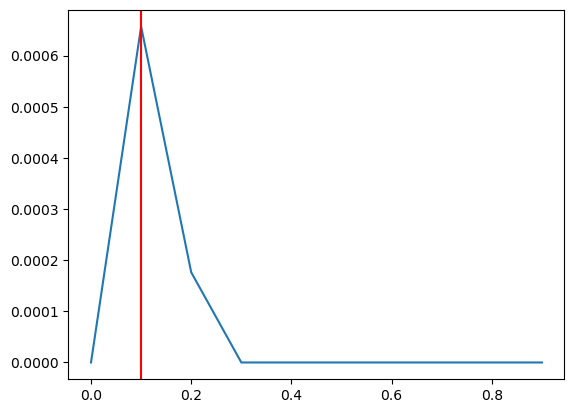

In [54]:
numerator = [2*a*b for a,b in zip(correct_genus_rate,correct_species_rate)]
denominator = [a+b for a,b in zip(correct_genus_rate,correct_species_rate)]
harmonic_mean = [a/b for a,b in zip(numerator,denominator)]
plt.plot(thresholds,harmonic_mean)
print("Best harmonic mean",max(harmonic_mean))
print("Best threshold",thresholds[harmonic_mean.index(max(harmonic_mean))])
plt.axvline(x=thresholds[harmonic_mean.index(max(harmonic_mean))],c='red',label="optimal threshold")
plt.axvline(x=thresholds[297],c='purple',label="threshold found in validation")
plt.title("Harmonic mean of species and genus correct rate")
plt.xlabel("threshold")
plt.ylabel("Harmonic mean")
plt.legend()
#plt.savefig("testoldfeatures.png")

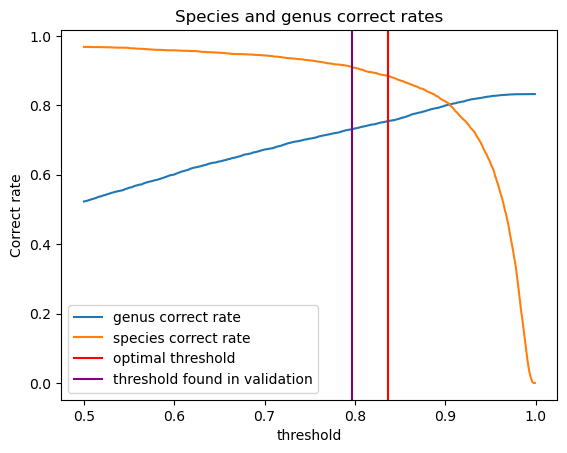

In [253]:
plt.plot(thresholds,correct_genus_rate[:],label="genus correct rate")
plt.plot(thresholds,correct_species_rate[:],label="species correct rate")
plt.axvline(x=thresholds[harmonic_mean.index(max(harmonic_mean))],c='red',label="optimal threshold")
plt.axvline(x=thresholds[297],c='purple',label="threshold found in validation")
plt.title("Species and genus correct rates")
plt.xlabel("threshold")
plt.ylabel("Correct rate")
plt.legend()
#plt.savefig("testoldfeaturesCR.png")

In [256]:
correct_genus_rate[index_of_threshold]

0.7313172043010753

In [257]:
correct_species_rate[index_of_threshold]

0.9094188376753507

In [258]:
harmonic_mean[index_of_threshold]

0.8107015691644405

In [259]:
#np.save("correct_rates/oldTestCGR.npy",correct_genus_rate)
#np.save("correct_rates/oldTestCSR.npy",correct_species_rate)

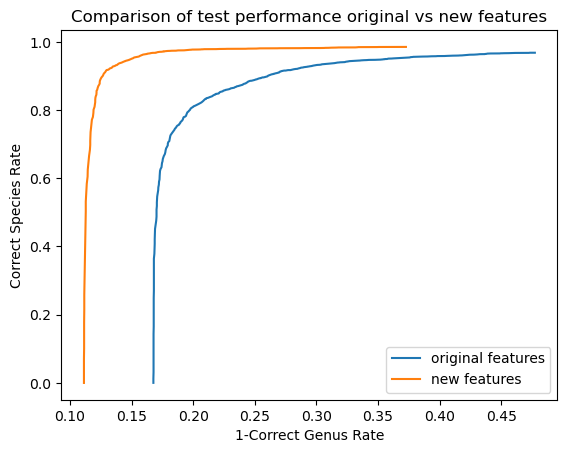

In [268]:
plt.plot(1-np.load("correct_rates/oldTestCGR.npy"),np.load("correct_rates/oldTestCSR.npy"),label='original features')
plt.plot(1-np.load("correct_rates/ourTestCGR.npy"),np.load("correct_rates/ourTestCSR.npy"),label="new features")
plt.title("Comparison of test performance original vs new features")
plt.xlabel("1-Correct Genus Rate")
plt.ylabel("Correct Species Rate")

plt.legend()
plt.savefig("test_comparison.png")

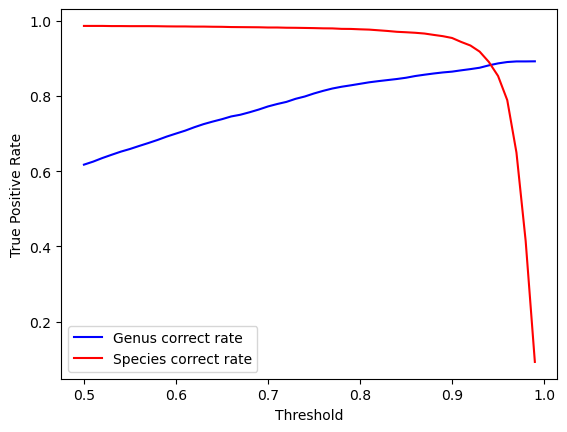

In [208]:
plt.plot(thresholds[-100:], correct_genus_rate[-100:], "-b", label="Genus correct rate")
plt.plot(thresholds[-100:], correct_species_rate[-100:], "-r", label="Species correct rate")

plt.xlabel("Threshold")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("GenusSpeciesCorrectRate.png")

In [22]:
species2genus[image_train_labels.long()][0]

tensor([234])

In [26]:
train_predicted_labels.shape

(19994,)

In [64]:
species2genus = species2genus.squeeze().numpy()

In [65]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(image_train_features, species2genus[image_train_labels.long()])
train_predicted_labels = clf.predict(image_train_features)
print(f"Training genus accuracy:{np.count_nonzero(train_predicted_labels==species2genus[image_train_labels.long()])/len(image_train_labels)}")
val_predicted_labels= clf.predict(image_val_features)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==species2genus[image_val_labels.long()])/len(image_val_labels)}")

Training genus accuracy:0.9991563770227778
Validation genus accuracy:0.608195542774982


In [63]:
train_predicted_labels

array([234, 234, 234, ..., 311, 311, 311])

In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_image_features)


In [68]:
new_val_predicted_labels= clf.predict(all_image_features)
print(f"Validation genus accuracy:{np.count_nonzero(new_val_predicted_labels==all_genus_labels)/len(all_genus_labels)}")

Validation genus accuracy:0.07018726591760299


In [41]:
complete_train_features_scaled.mean()

-4.1491620252380696e-18

In [44]:
X_scaled.mean()

-3.1008757e-10

In [48]:
import pickle
with open('get_unseen_fresh_samples/genusname2genuslabel.pickle', 'rb') as handle:
    genusname2genuslabel = pickle.load(handle)

In [49]:
genusname2genuslabel

{'Abax': 234,
 'Acleris': 235,
 'Acordulecera': 231,
 'Acrolophus': 232,
 'Acronicta': 233,
 'Adalia': 236,
 'Adelpha': 157,
 'Adrastus': 161,
 'Aedes': 160,
 'Agabus': 158,
 'Agonum': 159,
 'Agriophara': 175,
 'Agriotes': 174,
 'Agrotis': 37,
 'Agrypnus': 40,
 'Aleochara': 42,
 'Aloconota': 38,
 'Alosterna': 41,
 'Amara': 39,
 'Amaxia': 138,
 'Ametastegia': 140,
 'Amischa': 142,
 'Ammophila': 141,
 'Amorbia': 139,
 'Ampedus': 164,
 'Amphimallon': 167,
 'Anastrangalia': 168,
 'Andrena': 163,
 'Anisodactylus': 165,
 'Anisotoma': 166,
 'Anomis': 162,
 'Anopheles': 33,
 'Anoplodera': 35,
 'Antaeotricha': 30,
 'Anthicus': 31,
 'Anthidium': 34,
 'Anthobium': 32,
 'Aoplus': 36,
 'Apamea': 29,
 'Apion': 330,
 'Aplotarsus': 329,
 'Aproaerema': 331,
 'Araptus': 332,
 'Ardozyga': 327,
 'Arge': 328,
 'Argyrotaenia': 61,
 'Arhopalus': 60,
 'Armigeres': 59,
 'Astraptes': 62,
 'Athalia': 191,
 'Atheta': 188,
 'Athous': 189,
 'Atomaria': 190,
 'Aulacophora': 192,
 'Automeris': 187,
 'Bactrocera': 299

In [52]:
species2genus[4`]

231

In [75]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(X_train, y_train)
train_predicted_labels = clf.predict(X_train)
print(f"Training genus accuracy:{np.count_nonzero(train_predicted_labels==y_train)/len(y_train)}")
val_predicted_labels= clf.predict(X_test)
print(f"Validation genus accuracy:{np.count_nonzero(val_predicted_labels==y_test)/len(y_test)}")

Training genus accuracy:0.9998002496878902
Validation genus accuracy:0.9141073657927591


In [76]:
train_predicted_labels

array([ 95, 269,  95, ...,  68, 158, 254])

In [77]:
y_train

array([ 95, 269,  95, ...,  68, 158, 254])